In [439]:
import pandas as pd
import random
from IPython import display
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from collections import Counter, defaultdict
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect("game-log.sqlite", 2500)
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
pd.options.display.max_rows = 500
pd.options.display.precision = 2
plt.matplotlib.rcParams['figure.facecolor'] = "#fdf8ed"
plt.matplotlib.rcParams['axes.facecolor'] = (1,1,1,0)

In [440]:
pd.read_sql("""
select
    games.id, descA, descB, winner, datetime(date - 3600*5, 'unixepoch') start,
    format("%0.1f min ago", (unixepoch() - moves.time+1)/60) recent
from games
    left join moves on (games.id == moves.game)
group by moves.game having moves.time == max(moves.time)
order by date desc limit 30;
            """, conn, index_col='id', parse_dates='date')


,descA,descB,winner,start,recent
id,,,,,
960,od/50k,od/100k,,2024-02-02 16:10:41,96.6 min ago
959,fast/50k,od/50k,,2024-02-02 16:09:47,96.6 min ago
958,fastest/50k,hybrid/100k,,2024-02-02 16:07:38,96.5 min ago
957,hybrid/50k,hybrid/10k,A,2024-02-02 16:07:08,97.0 min ago
956,fast/50k,od/50k,,2024-02-02 16:06:10,96.5 min ago
955,fastest/50k,fastest/10k,A,2024-02-02 16:04:09,100.5 min ago
954,fast/50k,fastest/100k,,2024-02-02 16:03:13,96.5 min ago
953,hybrid/50k,fastest/50k,B,2024-02-02 16:02:38,97.9 min ago
952,hybrid/50k,fastest/50k,A,2024-02-02 16:00:46,100.0 min ago


In [441]:
games_df = pd.read_sql("select * from winners;", conn)
display.display(display.Markdown(f"# Summary: {len(games_df)} finished games"))
methods = set()
pairwise = defaultdict(Counter)
for _, row in games_df.iterrows():
    methods.add(row.winner); methods.add(row.loser)
    pairwise[row.loser][row.winner] += 1
pairwise = pd.DataFrame(pairwise)
methods = sorted(list(methods))
# Add missing pairs
pairwise = pairwise.reindex(methods).T.reindex(methods).T.fillna(0).astype(int)
pairwise.index.name = 'winner'
# Prepend a level
summary = pd.concat({"Pairwise": pairwise}, axis=1)
summary.insert(0, 'Total',     (pairwise.values + pairwise.T.values).sum(axis=1))
summary.insert(0, 'Win count',   pairwise.sum(axis=1))
summary.insert(0, 'Win percent', summary['Win count'] / summary['Total'])
all_elo = defaultdict(lambda: [])
# Run iterations of 100 ELO...
for _ in range(300):
    elo = defaultdict(lambda: 1000)
    # ... each ELO takes 20 random rounds, hopefully to convergence...
    for _ in range(20):
        for winner, loser in pd.read_sql(
                "select winner, loser from winners", conn).sample(frac=1.0).values:
            r1 = 10 ** (elo[winner] / 400)
            r2 = 10 ** (elo[loser] / 400)
            e1 = r1 / (r1+r2)
            e2 = r2 / (r1+r2)
            elo[winner] += 32 * (1.0-e1)
            elo[loser] += 32 * (0.0-e2)
    for k,v in elo.items():
        all_elo[k].append(v)
# after 200 rounds of 20-round ELO, all standard
# errors of the mean (np.std(v)/sqrt(len(v))
# are all within about 3 points
summary.insert(0, 'ELO', {k: np.mean(v) for k,v in all_elo.items()})
summary.sort_values('ELO', ascending=False)

# Summary: 927 finished games

ELO Win percent Win count Total  Pairwise           \
                                                    fast/100k fast/10k   
winner                                                                   
fast/100k       1203.60        0.71        90   126         8       12   
od/100k         1179.64        0.71        92   130         6        6   
odLog/100k      1143.66        0.69        84   122         4        4   
hybrid/100k     1136.12        0.67        86   129         4       11   
od/50k          1124.79        0.56        44    78         1        2   
fastest/100k    1103.93        0.61        84   137         5        6   
od/10k          1089.08        0.60        72   121         2        5   
hybrid/50k      1081.53        0.53        38    72         0        2   
fast/50k        1042.61        0.47        32    68         2        1   
fastest/50k     1022.03        0.43        29    68         1        2   
odLog/10k        920.22        0.46        65   140         2        8   
hybrid/10k       914.22        0.44        62   141         0        7   
fast/10k         877.46        0.38        50   133         1        4   
hybridlog/100k   856.77        0.39        45   115         0        5   
fastest/10k      756.34        0.26        37   144         0        8   
hybridlog/10k    548.00        0.13        17   130         0        0   

                                                                          \
               fast/50k fastest/100k fastest/10k fastest/50k hybrid/100k   
winner                                                                     
fast/100k             2            5          12           2           3   
od/100k               4            6           8           4           4   
odLog/100k            0            8           9           0           8   
hybrid/100k           2            1          13           1           4   
od/50k                6            2           2           9           1   
fastest/100k          0            8           3           4           5   
od/10k                2            5           6           6           3   
hybrid/50k            9            1           1           8           0   
fast/50k              4            0           3           2           5   
fastest/50k           6            0           2           2           2   
odLog/10k             0            6          16           0           5   
hybrid/10k            0            3           9           0           0   
fast/10k              0            2           6           0           2   
hybridlog/100k        0            1           8           0           1   
fastest/10k           1            5           5           1           0   
hybridlog/10k         0            0           4           0           0   

                                                                           \
               hybrid/10k hybrid/50k hybridlog/100k hybridlog/10k od/100k   
winner                                                                      
fast/100k               6          1              6             7       4   
od/100k                 7          2             11            10       5   
odLog/100k              7          0              9            15       4   
hybrid/100k            10          6              6             7       4   
od/50k                  0          5              0             0       2   
fastest/100k            7          2             11            11       6   
od/10k                  4          0              7             9       1   
hybrid/50k              3          6              0             0       0   
fast/50k                5          5              0             0       1   
fastest/50k             3          5              0             0       3   
odLog/10k               9          0              2             7       1   
hybrid/10k              7          1              8            11       1   
fast/10k     

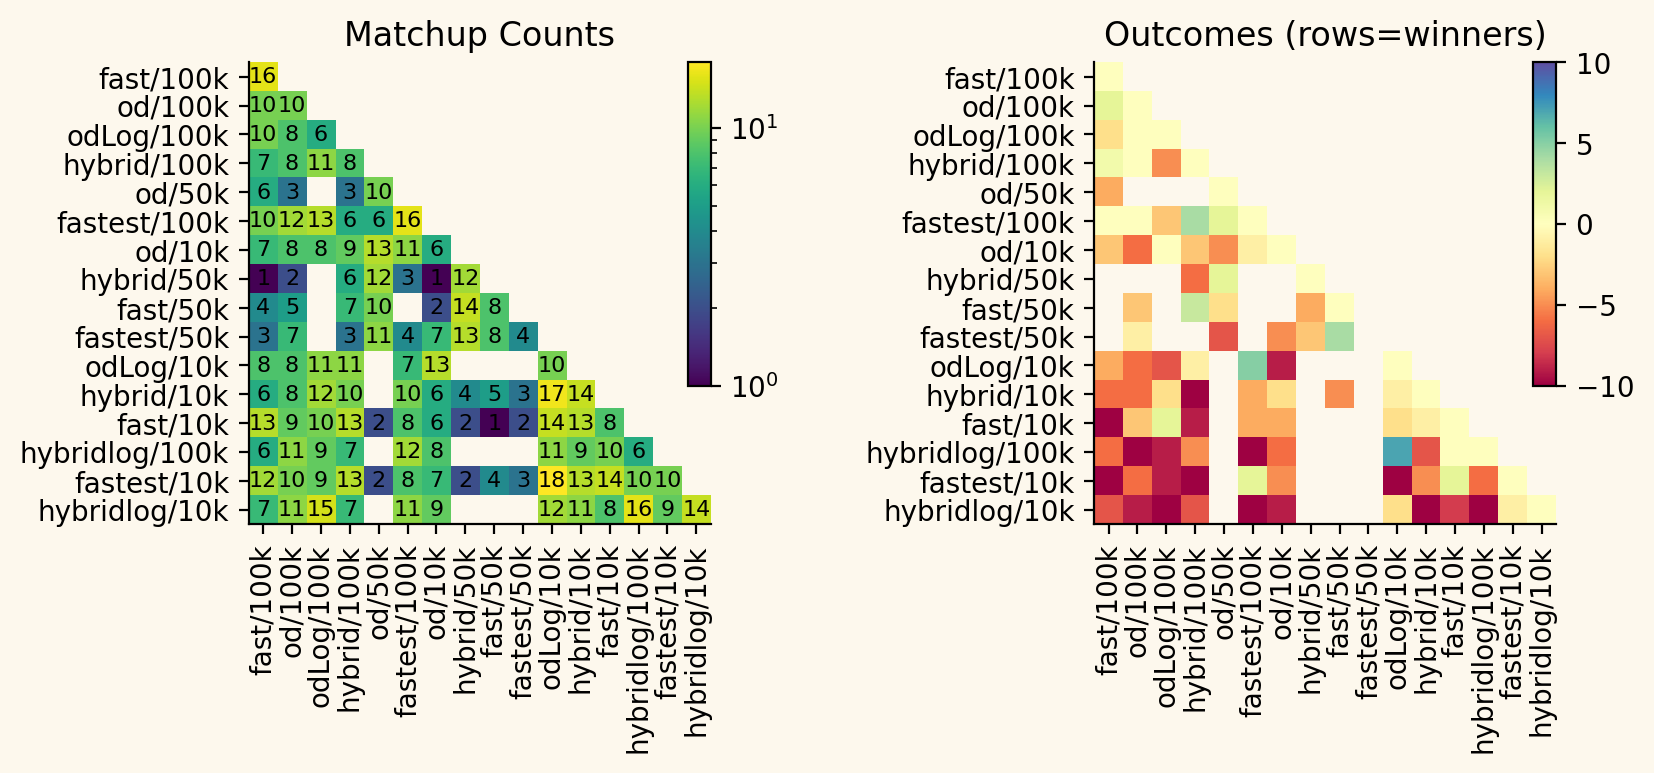

In [452]:
methods = sorted(methods, key=lambda x: -np.mean(all_elo[x]))
matchups = pairwise.loc[methods, methods]
matchups = np.tril(matchups.values + matchups.values.T).astype(float)
matchups[matchups==0] = np.nan
wins = pairwise.loc[methods, methods]
wins = np.tril(wins.values - wins.values.T).astype(float)
wins[np.tril(np.ones(len(wins))) == 0] = np.nan
wins[matchups < 5] = np.nan
wins[np.isnan(matchups)] = np.nan
fig,(axMatchups, axWins) = plt.subplots(1, 2, dpi=200, figsize=(10,3))
iM = axMatchups.imshow(matchups, cmap='viridis', norm=plt.matplotlib.colors.LogNorm())
iW = axWins.imshow(wins, cmap='Spectral', vmin=-10, vmax=10)
cM = axMatchups.inset_axes([0.95, 0.3, 0.05, 0.7])
fig.colorbar(iM, cax=cM)
cW = axWins.inset_axes([0.95, 0.3, 0.05, 0.7])
fig.colorbar(iW, cax=cW)
for ax in (axMatchups, axWins):
    plt.sca(ax)
    plt.xticks(np.arange(len(methods)), methods, rotation='vertical');
    plt.yticks(np.arange(len(methods)), methods);
    ax.spines[['top','right']].set_visible(False)
axMatchups.set_title("Matchup Counts")
axWins.set_title("Outcomes (rows=winners)")
for i in range(len(methods)):
    for j in range(len(methods)):
        c = matchups[j,i]
        if not np.isnan(c):
            axMatchups.annotate(f"{int(c)}", (i,j), size=8, ha='center',va='center')

In [443]:
pd.read_sql("""
with normalized_contestants as (
    select iif(winner >= loser, winner, loser) a,
    iif(winner >= loser, loser, winner) b
    from winners
),
methods as (
    select descA method from games union select descB from games
),
methodPairs as (
    select m1.method a, m2.method b from methods m1 join methods m2 where a >= b
),
occurrences as (
    select a, b, count(*) c from normalized_contestants group by a,b
)
select mp.a, mp.b, coalesce(o.c, 0) count from methodPairs mp left join occurrences o on (mp.a == o.a and mp.b == o.b) order by count;
""", conn)

,a,b,count
0,fastest/100k,fast/50k,0
1,hybridlog/100k,fast/50k,0
2,hybridlog/100k,fastest/50k,0
3,hybridlog/100k,hybrid/50k,0
4,hybridlog/10k,fast/50k,0
5,hybridlog/10k,fastest/50k,0
6,hybridlog/10k,hybrid/50k,0
7,od/50k,hybrid/10k,0
8,od/50k,hybridlog/100k,0
9,od/50k,hybridlog/10k,0


In [444]:
display.display(display.Markdown("## Total matchups (symmetric)"))
total = pd.DataFrame(pairwise.values + pairwise.T.values,
             index=pairwise.index,
             columns=pairwise.columns).rename_axis('').rename_axis('', axis=1)
display.display(total)
missing=[]
display.display(display.Markdown("## Matchups with less than 5 games"))
for a, row in total.iterrows():
    for b in total.columns[row < 5]:
        if a <= b:
            missing.append((a, b, total.loc[a,b]))
pd.DataFrame(missing, columns=['A','B','total games']).sort_values(['total games', 'A', 'B'])


## Total matchups (symmetric)

,fast/100k,fast/10k,fast/50k,fastest/100k,fastest/10k,fastest/50k,hybrid/100k,hybrid/10k,hybrid/50k,hybridlog/100k,hybridlog/10k,od/100k,od/10k,od/50k,odLog/100k,odLog/10k
,,,,,,,,,,,,,,,,
fast/100k,16,13,4,10,12,3,7,6,1,6,7,10,7,6,10,8
fast/10k,13,8,1,8,14,2,13,13,2,10,8,9,6,2,10,14
fast/50k,4,1,8,0,4,8,7,5,14,0,0,5,2,10,0,0
fastest/100k,10,8,0,16,8,4,6,10,3,12,11,12,11,6,13,7
fastest/10k,12,14,4,8,10,3,13,13,2,10,9,10,7,2,9,18
fastest/50k,3,2,8,4,3,4,3,3,13,0,0,7,7,11,0,0
hybrid/100k,7,13,7,6,13,3,8,10,6,7,7,8,9,3,11,11
hybrid/10k,6,13,5,10,13,3,10,14,4,9,11,8,6,0,12,17
hybrid/50k,1,2,14,3,2,13,6,4,12,0,0,2,1,12,0,0


## Matchups with less than 5 games

,A,B,total games
7,fast/50k,fastest/100k,0
9,fast/50k,hybridlog/100k,0
10,fast/50k,hybridlog/10k,0
12,fast/50k,odLog/100k,0
13,fast/50k,odLog/10k,0
22,fastest/50k,hybridlog/100k,0
23,fastest/50k,hybridlog/10k,0
24,fastest/50k,odLog/100k,0
25,fastest/50k,odLog/10k,0
28,hybrid/10k,od/50k,0


# Evaluation speed

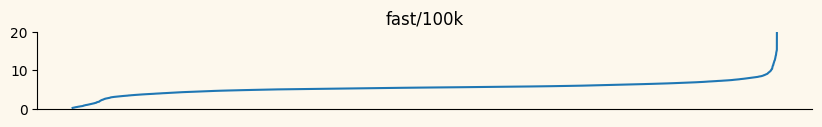

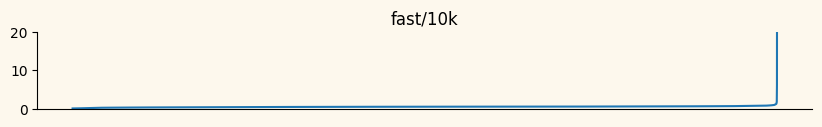

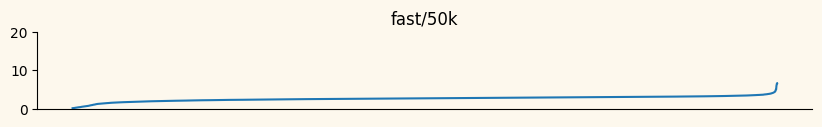

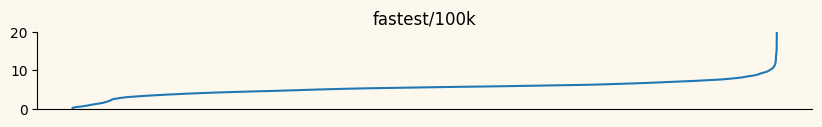

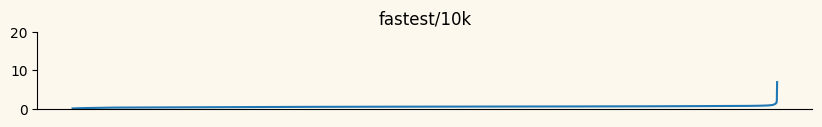

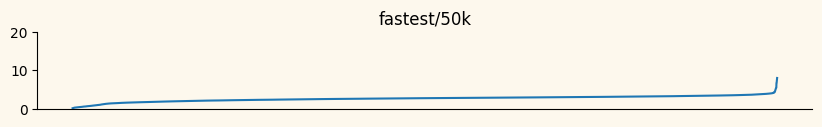

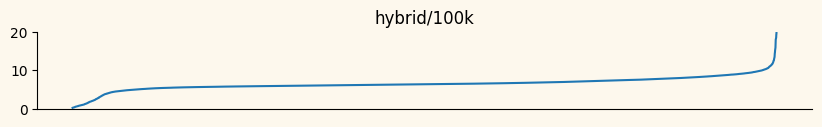

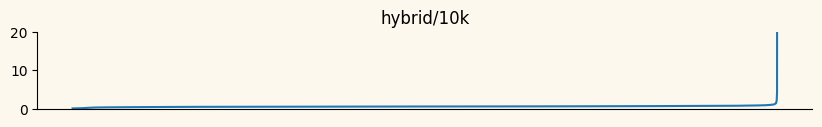

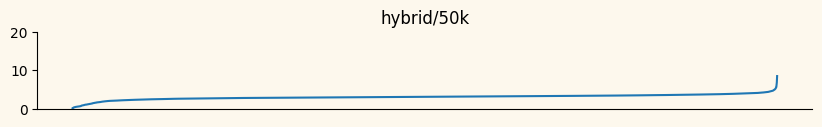

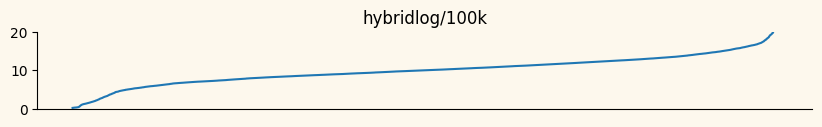

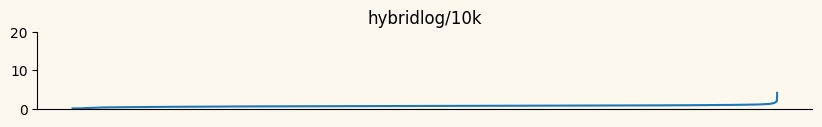

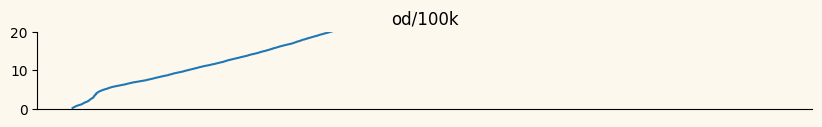

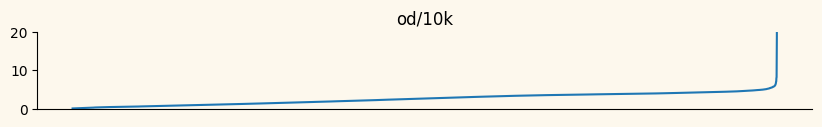

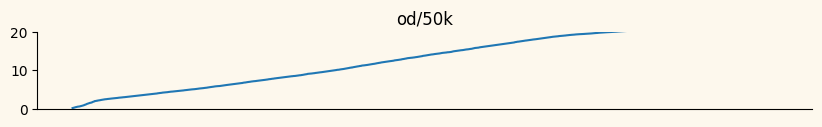

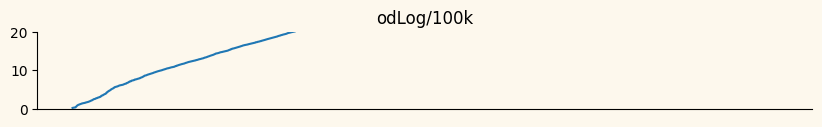

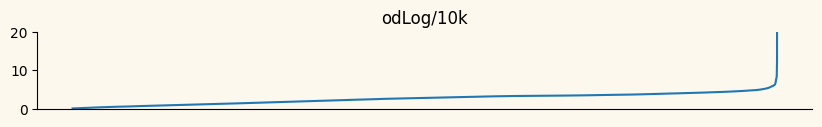

In [445]:
df = pd.read_sql("""
with descriptions as (
    select id, descA desc, "A" player from games union all select  id, descB, "B" from games
) select desc, thinkDuration from moves
inner join descriptions on (moves.game == descriptions.id and moves.player == descriptions.player)
where 0 < thinkDuration and thinkDuration < 60.0
""", conn).groupby('desc')
df.describe()
for desc, times in df.apply(lambda x: x.thinkDuration.tolist()).items():
    fig,ax = plt.subplots(figsize=(10, 1))
    ax.spines[['top','right']].set_visible(False)
    ax.plot(sorted(times))
    ax.set(xticks=[],title=desc,ylim=(0,20))